In [69]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
import numpy as np
import seaborn as sns

In [70]:
####pulling Haas Avocado sales data####

#Creating DataFrame,setting Date as the index and deleting unneeded column 
avocado = pd.read_csv('avocado.csv', parse_dates = True, index_col = 'Date')
del avocado['Unnamed: 0']

#create 'month' column (dataset already includes year column)
avocado['month'] = None
for index, row in avocado.iterrows():
    avocado.at[index, 'month'] = str(index.month)
avocado['month'] = pd.to_numeric(avocado['month'])

#renaming columns providing size classification for volume sold
avocado = avocado.rename(columns={"4046":"small volume sold","4225":"large volume sold","4770":"extra large volume sold"})

In [71]:
####pulling Mexico weather station data####
Mexico_df = pd.read_csv('Uruapan_Weather_Station_Data.csv')
# set the Date to standard time
Mexico_df["Date"] = pd.to_datetime(Mexico_df["Date"],errors='coerce')
# drop the row with nan
Mexico_df = Mexico_df.dropna(subset=['Date'])
# set the "Date" into standard time format
Mexico_df["Date"] = pd.to_datetime(Mexico_df[["Date"]].stack()).unstack()

In [72]:
# pulling San Diego weather data and avocado import data
San_df = pd.read_csv('San Diego (SAN) Weather Station Data.csv')

# set the Date to standard time
San_df["Date"] = pd.to_datetime(San_df["Date"],errors='coerce')

# drop the row with nan
San_df = San_df.dropna(subset=['Date'])
San_df.head()

# set the "Date" into standard time format
San_df["Date"] = pd.to_datetime(San_df[["Date"]].stack()).unstack()

In [73]:
###pull Avocado Import Data###
import_df = pd.read_csv('HAB_Arrival_Volume_All.csv')
# rename the "Week" in import dataframe to "Date"
import_df = import_df .rename(columns={"Week":"Date"})
# set the "Date" into standard time format
import_df["Date"] = pd.to_datetime(import_df[["Date"]].stack()).unstack()

In [74]:
###Merge Import and Weather Data###
import_df = import_df[["Date","Mexico","California"]]
# merge the Mexico weather data and import data
combined_data = pd.merge(import_df, Mexico_df, on="Date", how = "outer")

# add San Diego data to the combined dataset
combined_data = pd.merge(combined_data, San_df, on="Date", how = "outer")

# set the index column with date
combined_data=combined_data.set_index("Date")

# remove non-numeric rows in precipitation column
combined_data=combined_data[pd.to_numeric(combined_data['Precipitation'], errors='coerce').notnull()]
# convert the str in precipitation column into float number
combined_data.Precipitation = combined_data.Precipitation.astype(float)

#create "year" column
combined_data['year'] = None
for index, row in combined_data.iterrows():
    combined_data.at[index, 'year'] = str(index.year)
combined_data['year'] = pd.to_numeric(combined_data['year'])

#create 'month' column
combined_data['month'] = None
for index, row in combined_data.iterrows():
    combined_data.at[index, 'month'] = str(index.month)
combined_data['month'] = pd.to_numeric(combined_data['month'])
combined_data.head()

combined_data = combined_data.rename(columns={"Mean Daily Temperature":"Temp"})
# remove non-numeric rows in Temp column
combined_data=combined_data[pd.to_numeric(combined_data['Temp'], errors='coerce').notnull()]
# convert the str in Temp column into float number
combined_data.Temp = combined_data.Temp.astype(float)


In [75]:
#establish list of 8 major geographic regions used by the Haas Avocado Board
regions = ['California',
           'Plains',
           'West',
           'SouthCentral',
           'GreatLakes',
           'Midsouth',
           'Southeast',
           'Northeast']
###note: consider using isin() method to clean up the code for the regional queries

In [76]:
#select default matplotlib style
#style options are listed here: https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-colorblind')

In [92]:
#generating summary of total avocados sold each year, by region
regional_volumes = pd.DataFrame(avocado[(avocado.region == 'West') | 
        (avocado.region == 'California') |
       (avocado.region == 'Plains') |
       (avocado.region =='SouthCentral') |
       (avocado.region == 'GreatLakes') |
       (avocado.region == 'Midsouth') |
       (avocado.region == 'Southeast') |
       (avocado.region == 'Northeast')].pivot_table(values = 'Total Volume',index = 'year', columns = ['region'], aggfunc=np.sum))
regional_volumes = (regional_volumes/(10**6)).round(1)

In [78]:
type_volumes = pd.DataFrame(avocado[avocado['region'] == 'TotalUS'].pivot_table(values = 'Total Volume',index = 'year', columns = 'type', aggfunc=np.sum))
type_volumes = (type_volumes/(10**6)).round(1)
type_volumes

type,conventional,organic
year,,
2015,1623.7,33.6
2016,1770.3,48.9
2017,1801.8,62.9
2018,505.5,18.1


In [79]:
#generating DataFrame of total sales by type
regional_volumes_by_type = pd.DataFrame(avocado[(avocado.region == 'West') | 
        (avocado.region == 'California') |
       (avocado.region == 'Plains') |
       (avocado.region =='SouthCentral') |
       (avocado.region == 'GreatLakes') |
       (avocado.region == 'Midsouth') |
       (avocado.region == 'Southeast') |
       (avocado.region == 'Northeast') | (avocado.region == 'TotalUS')].pivot_table(values = 'Total Volume',index = ['type'], columns = ['region'], aggfunc=np.sum))
regional_volumes_by_type = (regional_volumes_by_type/(10**6)).round(1)
regional_volumes_by_type

region,California,GreatLakes,Midsouth,Northeast,Plains,SouthCentral,Southeast,TotalUS,West
type,,,,,,,,,
conventional,1003.6,567.6,490.4,689.1,302.9,993.2,605.2,5701.2,1049.4
organic,25.4,22.1,18.0,24.2,8.3,18.1,10.0,163.5,37.4


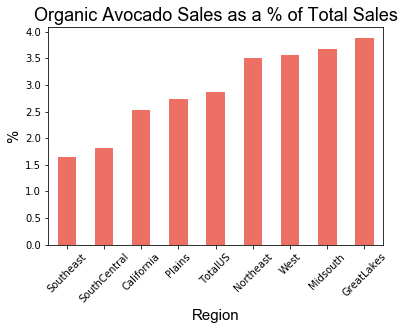

In [80]:
organic_share = pd.DataFrame(
    regional_volumes_by_type.loc['organic'] / regional_volumes_by_type.loc['conventional'])
organic_share = organic_share * 100
organic_share = organic_share.sort_values(by = [0])

organic_share.plot(kind = 'bar', legend = None, color = '#EC7063')
plt.title('Organic Avocado Sales as a % of Total Sales', fontname = 'Arial', fontsize = 18)
plt.ylabel('%', fontname = 'Arial', fontsize = 15)
plt.xlabel('Region', fontname = 'Arial', fontsize = 15)
plt.xticks(rotation = 45)
#plt.figure(figsize = [4.8,6.4])
plt.savefig('type_share_by_region.png', orientation = 'portrait', dpi = 1800, bbox_inches = 'tight')
plt.show()


In [81]:
#generating summary of average avocado prices each year, by region
regional_prices = pd.DataFrame(avocado[(avocado.region == 'West') | 
        (avocado.region == 'California') |
       (avocado.region == 'Plains') |
       (avocado.region =='SouthCentral') |
       (avocado.region == 'GreatLakes') |
       (avocado.region == 'Midsouth') |
       (avocado.region == 'Southeast') |
       (avocado.region == 'Northeast')].pivot_table(
    values = 'AveragePrice',index = 'year', columns = ['region'], aggfunc=np.mean
)).round(2)

In [86]:
#summary table of total avocados sold each year, by region
regional_volumes

region,California,GreatLakes,Midsouth,Northeast,Plains,SouthCentral,Southeast,West
year,,,,,,,,
2015,0.000301,0.000169,0.000140,0.000203,0.000088,0.000290,0.000160,0.000305
2016,0.000326,0.000178,0.000154,0.000219,0.000095,0.000304,0.000198,0.000345
2017,0.000318,0.000189,0.000166,0.000225,0.000100,0.000325,0.000197,0.000345


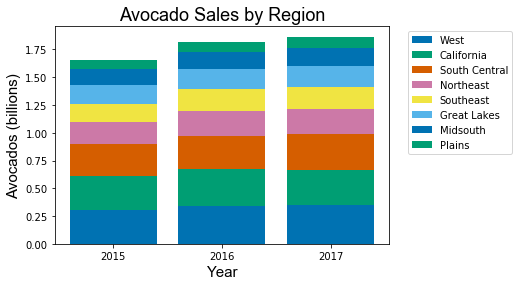

In [93]:
#generate stacked bar chart of regional volumes over time
#need to label each segment
ax = ['2015','2016','2017']
regional_volumes = regional_volumes.iloc[0:3]
#converting DataFrame to billions - for an easy-to-ready Y axis
regional_volumes = regional_volumes/(10**3)
plt.bar(ax,regional_volumes.West)
plt.bar(ax,regional_volumes.California, 
        bottom = regional_volumes.West)
plt.bar(ax,regional_volumes.SouthCentral, 
        bottom = regional_volumes.West + regional_volumes.California)
plt.bar(ax,regional_volumes.Northeast, 
        bottom = regional_volumes.West + regional_volumes.California + regional_volumes.SouthCentral)
plt.bar(ax,regional_volumes.Southeast, 
        bottom = regional_volumes.West + regional_volumes.California + regional_volumes.SouthCentral + regional_volumes.Northeast)
plt.bar(ax,regional_volumes.GreatLakes, 
        bottom = regional_volumes.West + regional_volumes.California + regional_volumes.SouthCentral + regional_volumes.Northeast + regional_volumes.Southeast)
plt.bar(ax,regional_volumes.Midsouth, 
        bottom = regional_volumes.West + regional_volumes.California + regional_volumes.SouthCentral + regional_volumes.Northeast + regional_volumes.Southeast + regional_volumes.GreatLakes)
plt.bar(ax,regional_volumes.Plains, 
        bottom = regional_volumes.West + regional_volumes.California + regional_volumes.SouthCentral + regional_volumes.Northeast + regional_volumes.Southeast + regional_volumes.GreatLakes + regional_volumes.Midsouth)
plt.title('Avocado Sales by Region', fontname = 'Arial', fontsize = 18)
plt.ylabel('Avocados (billions)', fontname = 'Arial', fontsize = 15)
plt.xlabel('Year', fontname = 'Arial', fontsize = 15)
plt.legend(['West',
            'California',
            'South Central',
            'Northeast',
            'Southeast',
            'Great Lakes',
           'Midsouth',
            'Plains'], bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig('volumes_by_region.png', orientation = 'landscape', dpi = 1800, bbox_inches = 'tight')
plt.show()

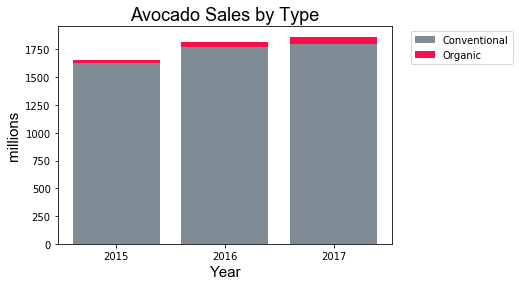

In [95]:
#generate stacked bar chart of organic vs. conventional
ax = ['2015','2016','2017']
plt.bar(ax,type_volumes.conventional.iloc[0:3], color = '#808B96')
plt.bar(ax,type_volumes.organic.iloc[0:3], 
        bottom = type_volumes.conventional.iloc[0:3], color = '#F70E4A')
plt.title('Avocado Sales by Type', fontname = 'Arial', fontsize = 18)
plt.ylabel('millions', fontname = 'Arial', fontsize = 15)
plt.xlabel('Year', fontname = 'Arial', fontsize = 15)
plt.legend(['Conventional','Organic'], bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('conventional_vs_organic_volumes.png', orientation = 'landscape', dpi = 1800, bbox_inches = 'tight')
plt.show()

In [17]:
#generate a pivot table that calculates average per unit avocado price by month
price_table = pd.DataFrame(avocado[(avocado['region'] == 'TotalUS') 
                                   & (avocado['type'] == 'conventional')].pivot_table(
values = 'AveragePrice',
    index = 'year',
    columns = 'month',
    aggfunc = 'mean'
))

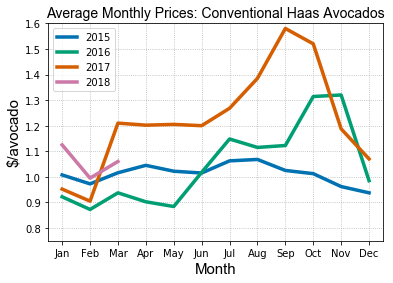

In [18]:
#Create Seasonal Plot of Average Monthly US Pricing
price_table.T.plot(linewidth = 3.5)
plt.title('Average Monthly Prices: Conventional Haas Avocados', fontname = 'Arial', fontsize = 14)
plt.xticks(np.arange(13),['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlim(0.5,12.5)
plt.ylim(0.75,1.6)
plt.ylabel('$/avocado',fontname = 'Arial', fontsize = 15)
plt.xlabel('Month', fontname = 'Arial', fontsize = 15)
plt.grid(linestyle =':')
plt.legend(loc = 0)
plt.savefig('seasonal_prices.png', orientation = 'landscape', dpi = 1800)
plt.show()


In [19]:
#generate a pivot table that calculates total volume by month
volume_table = pd.DataFrame(avocado[avocado['region'] == 'TotalUS'].pivot_table(
values = 'Total Volume',
    index = 'year',
    columns = 'month',
    aggfunc = 'sum'
))

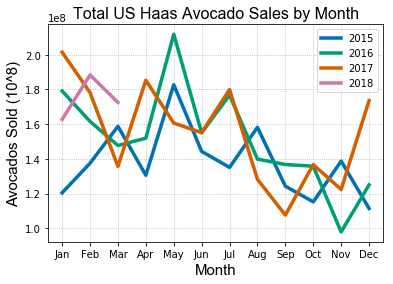

In [20]:
#Create a seasonality plot of total monthly US sales volume

#convert to millions - for easy-to-read Y axis
volume_table.T.plot(linewidth = 3.5)
plt.title('Total US Haas Avocado Sales by Month', fontname = 'Arial', fontsize = 16)
plt.xticks(np.arange(13),['','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlim(0.5,12.5)
plt.ylabel("Avocados Sold (10^8)",fontname = 'Arial', fontsize = 15)
plt.xlabel('Month', fontname = 'Arial', fontsize = 15)
plt.grid(linestyle =':')
plt.legend(loc = 0)
plt.savefig('seasonal_volume.png', orientation = 'landscape', dpi = 1800)
plt.show()

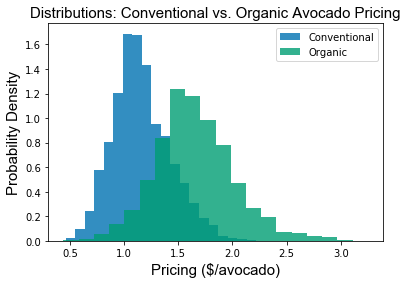

Ttest_indResult(statistic=-105.58784823721108, pvalue=0.0)

In [21]:
#t test - check price of organic vs. conventional avocados
conventional_prices = avocado[avocado['type'] == 'conventional']['AveragePrice']
organic_prices = avocado[avocado['type'] == 'organic']['AveragePrice']
plt.title('Distributions: Conventional vs. Organic Avocado Pricing', fontname = 'Arial', fontsize = 15)
plt.xlabel('Pricing ($/avocado)', fontname = 'Arial', fontsize = 15)
plt.ylabel('Probability Density', fontname = 'Arial', fontsize = 15)
plt.hist(conventional_prices, alpha = 0.8, bins =20, density = True)
plt.hist(organic_prices, alpha = 0.8, bins = 20, density = True)
plt.legend(['Conventional','Organic'])
plt.savefig('conventional_vs_organic_hist.png', orientation = 'landscape', dpi = 1800)
plt.show()
stats.ttest_ind(conventional_prices, organic_prices)

In [22]:
#there is a statistically significant difference in pricing of organic vs. conventional
stats.ttest_ind(conventional_prices, organic_prices)

Ttest_indResult(statistic=-105.58784823721108, pvalue=0.0)

In [23]:
#generating DataFrame of total sales by type
regional_volumes_by_type = pd.DataFrame(avocado[(avocado.region == 'West') | 
        (avocado.region == 'California') |
       (avocado.region == 'Plains') |
       (avocado.region =='SouthCentral') |
       (avocado.region == 'GreatLakes') |
       (avocado.region == 'Midsouth') |
       (avocado.region == 'Southeast') |
       (avocado.region == 'Northeast')].pivot_table(values = 'Total Volume',index = ['type'], columns = ['region'], aggfunc=np.sum))
regional_volumes_by_type = (regional_volumes_by_type/(10**6)).round(1)

In [24]:
regional_volumes_by_type

region,California,GreatLakes,Midsouth,Northeast,Plains,SouthCentral,Southeast,West
type,,,,,,,,
conventional,1003.6,567.6,490.4,689.1,302.9,993.2,605.2,1049.4
organic,25.4,22.1,18.0,24.2,8.3,18.1,10.0,37.4


In [25]:
regional_volumes_by_type.loc['organic'] / regional_volumes_by_type.loc['conventional']


region
California      0.025309
GreatLakes      0.038936
Midsouth        0.036705
Northeast       0.035118
Plains          0.027402
SouthCentral    0.018224
Southeast       0.016523
West            0.035639
dtype: float64

In [26]:
#conventional prices by region
conventional_prices_by_region = pd.DataFrame(avocado[(avocado.region == 'West') | 
        (avocado.region == 'California') |
       (avocado.region == 'Plains') |
       (avocado.region =='SouthCentral') |
       (avocado.region == 'GreatLakes') |
       (avocado.region == 'Midsouth') |
       (avocado.region == 'Southeast') |
       (avocado.region == 'Northeast') & (avocado.type == 'conventional')]).iloc[:,[0,11]]

conventional_prices_by_region = conventional_prices_by_region.pivot_table(values = 'AveragePrice', columns = 'region', index = 'Date')


In [27]:
#establish empty dataframe where calculated p values will be stored
p_matrix = pd.DataFrame(data = 0, columns = regions, index = range(0,8), dtype = 'float64')

In [28]:
#populate the p value matrix...
#...by iterating through each column
for column in p_matrix:
#...and while in each column iterating through each row
    for index, row in p_matrix.iterrows():
        p_matrix.at[index, column]  = stats.ttest_ind(conventional_prices_by_region[regions[index]], 
                    conventional_prices_by_region[column])[1]
#Assign regional labels to the index dataframe        
p_matrix.index = regions

In [29]:
p_matrix

,California,Plains,West,SouthCentral,GreatLakes,Midsouth,Southeast,Northeast
California,1.000000e+00,6.341199e-02,6.590128e-06,2.490739e-33,1.322240e-02,6.690629e-01,9.093218e-01,3.314521e-02
Plains,6.341199e-02,1.000000e+00,1.974743e-12,2.348163e-62,3.650823e-08,5.378956e-02,3.769094e-02,1.273490e-06
West,6.590128e-06,1.974743e-12,1.000000e+00,1.578327e-13,4.421977e-03,8.383712e-09,2.704311e-07,2.965299e-03
SouthCentral,2.490739e-33,2.348163e-62,1.578327e-13,1.000000e+00,3.965814e-35,7.453772e-55,1.071180e-44,1.519809e-32
GreatLakes,1.322240e-02,3.650823e-08,4.421977e-03,3.965814e-35,1.000000e+00,1.556831e-04,2.183414e-03,7.624656e-01
Midsouth,6.690629e-01,5.378956e-02,8.383712e-09,7.453772e-55,1.556831e-04,1.000000e+00,7.139377e-01,1.301264e-03
Southeast,9.093218e-01,3.769094e-02,2.704311e-07,1.071180e-44,2.183414e-03,7.139377e-01,1.000000e+00,9.114795e-03
Northeast,3.314521e-02,1.273490e-06,2.965299e-03,1.519809e-32,7.624656e-01,1.301264e-03,9.114795e-03,1.000000e+00


In [30]:
#export the p value matrix to a csv file
p_matrix.to_csv('p_matrix.csv')

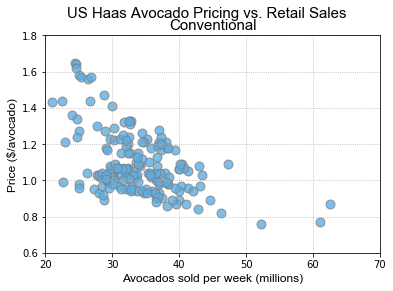

In [31]:
####Price Elasticity####
#plt.subplots(nrows=2, ncols=0)
plt.suptitle("US Haas Avocado Pricing vs. Retail Sales", fontname = 'Arial', fontsize = 15)
US_total_volume = avocado[(avocado.region == 'TotalUS') 
                          & (avocado.type == 'conventional')]['Total Volume']/10**6
US_prices = avocado[(avocado.region == 'TotalUS') & (avocado.type == 'conventional')]['AveragePrice']
#plt.subplot(2, 1, 1)
plt.scatter(y=US_prices,x=US_total_volume, color = '#5DADE2', alpha = 0.8, edgecolors = 'gray', s = 80)
plt.title('Conventional', fontname = 'Arial', fontsize = 15)
plt.ylabel("Price ($/avocado)", fontname= 'Arial', fontsize = 12)
plt.xlabel("Avocados sold per week (millions)", fontname = 'Arial', fontsize = 12)
plt.xlim(20,70)
plt.ylim(0.6,1.8)
plt.grid(linestyle =':')
plt.savefig('conventional_Scatter.png', orientation = 'landscape', dpi = 1800, bbox_inches='tight')
plt.show()

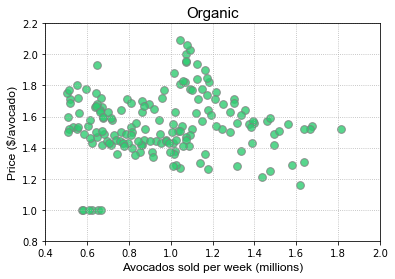

In [32]:
US_total_volume = avocado[(avocado.region == 'TotalUS') 
                          & (avocado.type == 'organic')]['Total Volume']/10**6
US_prices = avocado[(avocado.region == 'TotalUS') & (avocado.type == 'organic')]['AveragePrice']
plt.scatter(y=US_prices,x=US_total_volume, color = '#2ECC71', alpha = 0.8, edgecolors = 'gray', s = 60)
plt.title('Organic', fontname = 'Arial', fontsize = 15)
plt.ylabel("Price ($/avocado)", fontname= 'Arial', fontsize = 12)
plt.xlabel("Avocados sold per week (millions)", fontname = 'Arial', fontsize = 12)
plt.xlim(0.4,2.0)
plt.ylim(0.8,2.2)
plt.grid(linestyle =':')
plt.savefig('Organic_Scatter.png', orientation = 'landscape', dpi = 1800,bbox_inches='tight')
plt.show()

In [34]:
#establish empty dataframe where correlations will be stored
correl_matrix = pd.DataFrame(data = 0, columns = regions, index = ['conventional','organic'], dtype = 'float64')
correl_matrix['TotalUS'] = 0.0

In [35]:
#populate the correlation matrix
for column in correl_matrix:
    correl_matrix.at['conventional',column] = avocado[(avocado.type == 'conventional') 
        & (avocado.region == column)][['AveragePrice','Total Volume']].corr().iloc[0,1]
    correl_matrix.at['organic',column] = avocado[(avocado.type == 'organic') 
        & (avocado.region == column)][['AveragePrice','Total Volume']].corr().iloc[0,1]

In [36]:
correl_matrix

,California,Plains,West,SouthCentral,GreatLakes,Midsouth,Southeast,Northeast,TotalUS
conventional,-0.664373,-0.53886,-0.628404,-0.551220,-0.558584,-0.358251,-0.494509,-0.404580,-0.509960
organic,-0.484071,-0.39327,-0.676837,-0.439977,-0.435942,0.038074,-0.277675,-0.355498,0.024432


In [37]:
#generating a table of weekly avocado prices by region
regional_price_table = pd.DataFrame(avocado[(avocado.region == 'West') | 
        (avocado.region == 'California') |
       (avocado.region == 'Plains') |
       (avocado.region =='SouthCentral') |
       (avocado.region == 'GreatLakes') |
       (avocado.region == 'Midsouth') |
       (avocado.region == 'Southeast') |
       (avocado.region == 'Northeast') & (avocado.type == 'conventional')].pivot_table(
    values = 'AveragePrice',index = 'Date', columns = ['region'], aggfunc=np.mean
)).round(2)

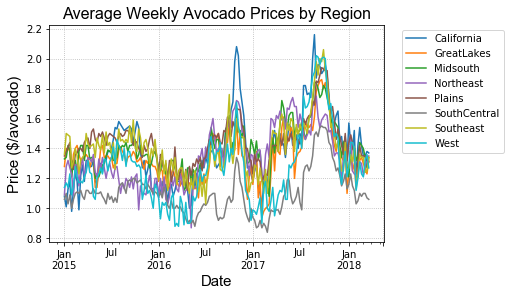

In [38]:
regional_price_table.plot(colormap = 'tab10')
plt.title('Average Weekly Avocado Prices by Region', fontname = 'Arial', fontsize = 16)
plt.ylabel("Price ($/avocado)", fontname = 'Arial', fontsize = 15)
plt.xlabel("Date", fontname = 'Arial', fontsize = 15)
plt.grid(linestyle =':')
plt.legend(loc = 0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Regional_price_linechart.png', orientation = 'landscape', dpi = 1800, bbox_inches = 'tight')
plt.show()

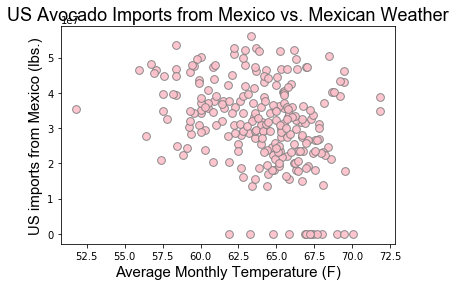

In [39]:
###Plotting imports vs. weather data

plt.scatter(y=combined_data['Mexico'],x=combined_data['Actual Average Daily Temperature (Degrees Farenheit)'], color = 'pink', alpha = 0.9, edgecolors = 'gray', s = 60)
plt.title('US Avocado Imports from Mexico vs. Mexican Weather', fontname = 'Arial', fontsize = 18)
plt.ylabel('US imports from Mexico (lbs.)', fontname = 'Arial', fontsize = 15)
plt.xlabel('Average Monthly Temperature (F)', fontname = 'Arial', fontsize = 15)


# plt.ylim(0,5)
plt.show()


In [64]:
temp_table = pd.DataFrame(combined_data[(combined_data.year == 2014) |
        (combined_data.year == 2015) |
        (combined_data.year == 2016) |
        (combined_data.year == 2017) |
        (combined_data.year == 2018)].pivot_table(
values = 'Actual Average Daily Temperature (Degrees Farenheit)',
    index = 'year',
    columns = 'month',
    aggfunc = np.mean
)).round(2)
temp_table
supply_table = pd.DataFrame(combined_data[ 
        (combined_data.year == 2015) |
        (combined_data.year == 2016) |
        (combined_data.year == 2017) |
        (combined_data.year == 2018)].pivot_table(
values = 'Mexico',
    index = 'year',
    columns = 'month',
    aggfunc = np.sum
)).round(2)

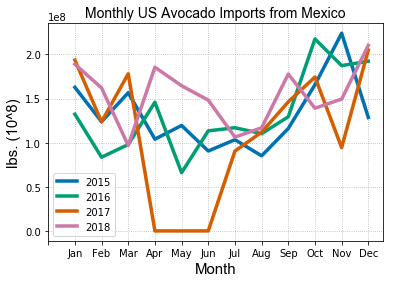

In [65]:
# plot the graph describes the avocado supply trend in California from 2014 to 2018 (line graph)
supply_table.T.plot(linewidth = 3.5)
plt.title('Monthly US Avocado Imports from Mexico', fontname = 'Arial', fontsize = 14)
plt.xticks(np.arange(13),[' ','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('lbs. (10^8)',fontname = 'Arial', fontsize = 15)
plt.xlabel('Month', fontname = 'Arial', fontsize = 15)
plt.grid(linestyle =':')
plt.legend(loc = 0)
plt.savefig('Total Monthly Supply of Avocado in Mexico.png', orientation = 'landscape', dpi = 1800)
plt.show()

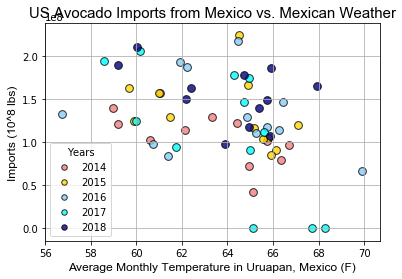

In [100]:
# Obtain the x and y coordinates for the year of 2014
## Retrieve the data with the year 2014
data_2014 = combined_data.loc[combined_data["year"] == 2014,:]
total_monthly_supply_2014 = data_2014.groupby('month')["Mexico"].sum()
average_monthly_temp_2014 = data_2014.groupby('month')["Actual Average Daily Temperature (Degrees Farenheit)"].mean()

# Obtain the x and y coordinates for the year of 2015
## Retrieve the data with the year 2015
data_2015 = combined_data.loc[combined_data["year"] == 2015,:]
total_monthly_supply_2015 = data_2015.groupby('month')["Mexico"].sum()
average_monthly_temp_2015 = data_2015.groupby('month')["Actual Average Daily Temperature (Degrees Farenheit)"].mean()

# Obtain the x and y coordinates for the year of 2016
## Retrieve the data with the year 2016
data_2016 = combined_data.loc[combined_data["year"] == 2016,:]
total_monthly_supply_2016 = data_2016.groupby('month')["Mexico"].sum()
average_monthly_temp_2016 = data_2016.groupby('month')["Actual Average Daily Temperature (Degrees Farenheit)"].mean()

# Obtain the x and y coordinates for the year of 2017
## Retrieve the data with the year 2017
data_2017 = combined_data.loc[combined_data["year"] == 2017,:]
total_monthly_supply_2017 = data_2017.groupby('month')["Mexico"].sum()
average_monthly_temp_2017 = data_2017.groupby('month')["Actual Average Daily Temperature (Degrees Farenheit)"].mean()

# Obtain the x and y coordinates for the year of 2018
## Retrieve the data with the year 2018
data_2018 = combined_data.loc[combined_data["year"] == 2018,:]
total_monthly_supply_2018 = data_2018.groupby('month')["Mexico"].sum()
average_monthly_temp_2018 = data_2018.groupby('month')["Actual Average Daily Temperature (Degrees Farenheit)"].mean()

# Build the scatter plots for each year
scatter2014 = plt.scatter(average_monthly_temp_2014, total_monthly_supply_2014, s=60,
            marker="o", facecolors="lightcoral", edgecolors="black", alpha=0.8, label = "2014")
scatter2015 = plt.scatter(average_monthly_temp_2015, total_monthly_supply_2015, s=60,
            marker="o", facecolors="gold", edgecolors="black", alpha=0.8, label = "2015")
scatter2016 = plt.scatter(average_monthly_temp_2016, total_monthly_supply_2016, s=60,
            marker="o", facecolors="lightskyblue", edgecolors="black", alpha=0.8, label = "2016")
scatter2017 = plt.scatter(average_monthly_temp_2017, total_monthly_supply_2017, s=60,
            marker="o", facecolors="cyan", edgecolors="black", alpha=0.8, label = "2017")
scatter2018 = plt.scatter(average_monthly_temp_2018, total_monthly_supply_2018, s=60,
            marker="o", facecolors="navy", edgecolors="black", alpha=0.8, label = "2018")

# Incorporate the other graph properties
plt.title("US Avocado Imports from Mexico vs. Mexican Weather",fontname = 'Arial', fontsize = 15)
plt.xlabel("Average Monthly Temperature in Uruapan, Mexico (F)",fontname = 'Arial', fontsize = 12)
plt.ylabel("Imports (10^8 lbs)",fontname = 'Arial', fontsize = 12)
plt.grid(True)
# Create a legend
lgnd = plt.legend(loc="best",title = "Years")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]
plt.savefig('MX_Weather_Scatter.png', orientation = 'landscape', dpi = 1800,bbox_inches = 'tight')
plt.show()

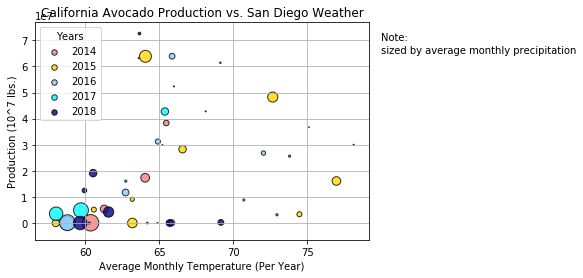

In [101]:
# Obtain the x and y coordinates for the year of 2014
## Retrieve the data with the year 2014
data_2014 = combined_data.loc[combined_data["year"] == 2014,:]
total_monthly_precipitation_2014 = data_2014.groupby('month')['Precipitation'].sum()
total_monthly_supply_2014 = data_2014.groupby('month')["California"].sum()
average_monthly_temp_2014 = data_2014.groupby('month')["Temp"].mean()

# Obtain the x and y coordinates for the year of 2015
## Retrieve the data with the year 2015
data_2015 = combined_data.loc[combined_data["year"] == 2015,:]
total_monthly_precipitation_2015 = data_2015.groupby('month')['Precipitation'].sum()
total_monthly_supply_2015 = data_2015.groupby('month')["California"].sum()
average_monthly_temp_2015 = data_2015.groupby('month')["Temp"].mean()

# Obtain the x and y coordinates for the year of 2016
## Retrieve the data with the year 2016
data_2016 = combined_data.loc[combined_data["year"] == 2016,:]
total_monthly_precipitation_2016 = data_2016.groupby('month')['Precipitation'].sum()
total_monthly_supply_2016 = data_2016.groupby('month')["California"].sum()
average_monthly_temp_2016 = data_2016.groupby('month')["Temp"].mean()

# Obtain the x and y coordinates for the year of 2017
## Retrieve the data with the year 2017
data_2017 = combined_data.loc[combined_data["year"] == 2017,:]
total_monthly_precipitation_2017 = data_2017.groupby('month')['Precipitation'].sum()
total_monthly_supply_2017 = data_2017.groupby('month')["California"].sum()
average_monthly_temp_2017 = data_2017.groupby('month')["Temp"].mean()

# Obtain the x and y coordinates for the year of 2018
## Retrieve the data with the year 2018
data_2018 = combined_data.loc[combined_data["year"] == 2018,:]
total_monthly_precipitation_2018 = data_2018.groupby('month')['Precipitation'].sum()
total_monthly_supply_2018 = data_2018.groupby('month')["California"].sum()
average_monthly_temp_2018 = data_2018.groupby('month')["Temp"].mean()

# Build the scatter plots for each year
scatter2014 = plt.scatter(average_monthly_temp_2014, total_monthly_supply_2014, s=total_monthly_precipitation_2014*60,
            marker="o", facecolors="lightcoral", edgecolors="black", alpha=0.8, label = "2014")
scatter2015 = plt.scatter(average_monthly_temp_2015, total_monthly_supply_2015, s=total_monthly_precipitation_2015*60,
            marker="o", facecolors="gold", edgecolors="black", alpha=0.8, label = "2015")
scatter2016 = plt.scatter(average_monthly_temp_2016, total_monthly_supply_2016, s=total_monthly_precipitation_2016*60,
            marker="o", facecolors="lightskyblue", edgecolors="black", alpha=0.8, label = "2016")
scatter2017 = plt.scatter(average_monthly_temp_2017, total_monthly_supply_2017, s=total_monthly_precipitation_2017*60,
            marker="o", facecolors="cyan", edgecolors="black", alpha=0.8, label = "2017")
scatter2018 = plt.scatter(average_monthly_temp_2018, total_monthly_supply_2018, s=total_monthly_precipitation_2018*60,
            marker="o", facecolors="navy", edgecolors="black", alpha=0.8, label = "2018")

# Incorporate the other graph properties
plt.title("California Avocado Production vs. San Diego Weather")
plt.xlabel("Average Monthly Temperature (Per Year)")
plt.ylabel("Production (10^7 lbs.)")
plt.grid(True)
# Create a legend
lgnd = plt.legend(loc="best",title = "Years")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]
# Incorporate a text label regarding circle size
plt.text(80,70000000,"Note:")
plt.text(80,65000000,"sized by average monthly precipitation" )
plt.savefig('CA_Weather_Scatter.png', orientation = 'landscape', dpi = 1800,bbox_inches = 'tight')
plt.show()